In [22]:
#this enviorment use LLM
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gc
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.utils import save_image
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("CUDA is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU: NVIDIA GeForce RTX 2080 Ti


In [6]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 2080 Ti , device num:0


In [3]:
def imshow(img1):
    img1 = torchvision.utils.make_grid(img1)
    image1 = img1 / 2 + 0.5     # unnormalize
    npimg1 = image1.detach().numpy()
    new = npimg1, (1, 2, 0)
    #print(np.img)
    #print(new)
    plt.imshow(np.transpose(npimg1, (1, 2, 0)))
    plt.show()
    plt.pause(0.005)

In [28]:
color = 1
def get_exponential_beta_schedule(timesteps, beta_min=1e-4, beta_max=0.02):
    """
    指数调度的 beta_t
    :param timesteps: 总的时间步数
    :param beta_min: 初始 beta 值
    :param beta_max: 最终 beta 值
    :return: beta_t 列表
    """
    t = torch.arange(0, timesteps, dtype=torch.float32)
    return beta_min * (beta_max / beta_min) ** (t / timesteps)
beta_schedule = get_exponential_beta_schedule(timesteps=1000).to(device)

class UNet(nn.Module):
    def __init__(self, input_channels=color, output_channels=color, hidden_dim=64):
        super(UNet, self).__init__()

        def block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.SiLU()
            )

        self.encoder = nn.Sequential(
            block(input_channels, hidden_dim),
            block(hidden_dim, hidden_dim * 2),
            block(hidden_dim * 2, hidden_dim * 4),
            block(hidden_dim * 4, hidden_dim * 8),
        )
        self.decoder = nn.Sequential(
            block(hidden_dim * 8, hidden_dim * 4),
            block(hidden_dim * 4, hidden_dim * 2),
            block(hidden_dim * 2, hidden_dim),
            block(hidden_dim, output_channels),
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
'''
color=3
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        ##
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, color, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x
'''
# 简单的高斯噪声扩散过程
class DiffusionModel:
    def __init__(self, model, T=1000):
        self.model = model
        self.T = T  # 扩散步骤数

    def forward_diffusion(self, x0, t):
        #give a noise which shape like x0
        noise = torch.randn_like(x0)
        #alpha_t = if t is larger, means step is larger, then the alpha is smaller, and the image is more noisy
        #alpha_t = 1 - 0.02 * t
        #alpha_t = torch.clamp(alpha_t, min=1e-5)  # 简单的线性调度
        #print(alpha_t.size())
        #print(f"alpha_t min/max: {alpha_t.min().item()} / {alpha_t.max().item()}")
        #alpha_t.view(-1, 1, 1, 1): adjust tensor dim, e.g. [a, b, c] to [ [[[a]]], [[[b]]], [[[c]]]] ]
        beta_t = beta_schedule[t]
        beta_t = beta_t.view(-1, 1, 1, 1)
        #alpha_t = alpha_t.view(-1, 1, 1, 1)
        #print(f'[alpha_t shape:{alpha_t.shape}]')
        #print(f'[x0 shape:{x0.shape}]')
        #torch.sqrt: square each num in tensor
        noisy_img = torch.sqrt(beta_t) * x0 + torch.sqrt(1 - beta_t) * noise
        return noisy_img, noise

    def reverse_diffusion(self, noisy_img, t):
        predicted_noise = self.model(noisy_img)
        #alpha_t = 1 - 0.02 * t
        #alpha_t = torch.clamp(alpha_t,min=1e-5)
        #alpha_t = alpha_t.view(-1, 1, 1, 1)
        beta_t = beta_schedule[t]
        beta_t = beta_t.view(-1,1,1,1)
        denoised_img = (noisy_img - torch.sqrt(1 - beta_t) * predicted_noise) / torch.sqrt(beta_t)
        return denoised_img

In [ ]:
# 准备数据集 (MNIST)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# 初始化模型和优化器
model = UNet().to(device)
diffusion_model = DiffusionModel(model)
#optimizer = optim.Adam(model.parameters(), lr=1e-5)
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-2)

# 定义 ReduceLROnPlateau 学习率调度器，监控模型的损失变化
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
loss_fn = nn.MSELoss()

# 训练过程
num_epochs = 300
timesteps = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (x, _) in enumerate(train_loader):
        #clear_output(wait=True)

        x = x.to(device)

        #t = torch.randint(0, 1000, (x.size(0),), device=device)  # 随机选择一个扩散步骤
        #t 是一个形状为 [batch_size] 的张量，每个样本对应一个扩散步数。
        #if u write t = torch.randint(0, 50, (batch_size,3,32,32), device=device), then u have different steps in each pixel
        t = torch.randint(0, timesteps, (x.size(0),), device=device)
        noisy_img, noise = diffusion_model.forward_diffusion(x, t)

        predicted_noise = model(noisy_img)
        loss = loss_fn(predicted_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        #imshow(noisy_img)
        #imshow(torchvision.utils.make_grid(real_imgs))

        #if batch_idx % 100 == 0:
        #    print(f'Epoch [{epoch}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}")
    scheduler.step(avg_loss)

    if epoch % 10 == 0:
        with torch.no_grad():
            sample_img = diffusion_model.reverse_diffusion(noisy_img, t)
            plt.imshow(sample_img[0].cpu().squeeze(), cmap='gray')
            plt.show()
    
    del noisy_img, loss, noise
    torch.cuda.empty_cache()
    gc.collect()

tensor([314, 184, 206, 284, 360, 190, 387, 485,  68, 148, 350, 178, 355, 445,
         27,  17, 252,  32, 291,  43, 459, 237, 344, 491, 455, 329, 274,  56,
        392, 163, 468,  63,  45, 441,  56, 349, 343, 491, 421, 135, 126, 351,
        211, 349, 351, 161, 254, 124, 252,  53, 391, 354, 496, 378,  56, 284,
        373, 148, 189, 485, 391, 203,  51, 259], device='cuda:0')
False
tensor(52502.2148, device='cuda:0', grad_fn=<MeanBackward0>)
False
tensor(52502.2148, device='cuda:0', grad_fn=<MeanBackward0>)
False
tensor(52502.2148, device='cuda:0', grad_fn=<MeanBackward0>)
False
tensor(52502.2148, device='cuda:0', grad_fn=<MeanBackward0>)
False
tensor(52502.2148, device='cuda:0', grad_fn=<MeanBackward0>)
False
tensor(52502.2148, device='cuda:0', grad_fn=<MeanBackward0>)
False
tensor(52502.2148, device='cuda:0', grad_fn=<MeanBackward0>)
False
tensor(52502.2148, device='cuda:0', grad_fn=<MeanBackward0>)


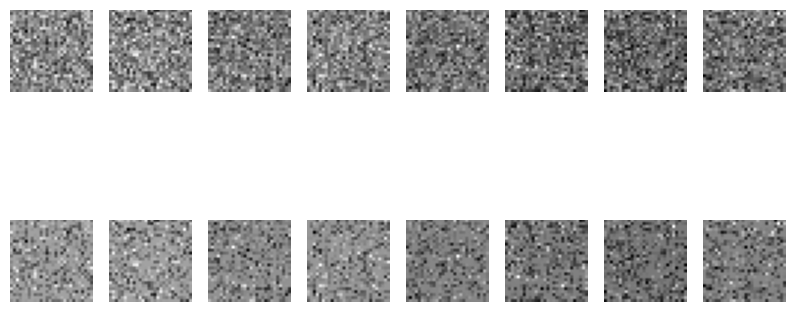

Denoised Image Range Before Reverse Normalize: -1277.7822265625 / 1007.9097290039062
Noisy Image Range: -1.114240288734436 1.4288139343261719
Denoised Image Range: -393.5539855957031 310.6676940917969


In [20]:
''' 
# 生成图像
model.eval()
sample_batch = next(iter(train_loader))[0].to(device)
batch_size = sample_batch.size(0)
t = torch.randint(0, timesteps, (batch_size,), device=device)
noisy_img, _ = diffusion_model.forward_diffusion(sample_batch, t)
denoised_img = diffusion_model.reverse_diffusion(noisy_img, t)
if t % 50 == 0:
        plt.imshow(noisy_img.cpu().squeeze().permute(1, 2, 0).numpy())
        plt.title(f"Timestep {t}")
        plt.show()
'''
# 生成图像
model.eval()
#sample_batch : a batch of images
sample_batch = next(iter(train_loader))[0].to(device)
batch_size = sample_batch.size(0)
t = torch.randint(0, timesteps, (batch_size,), device=device)
print(t)
#t = t.view(-1, 1, 1, 1)
noisy_img, _ = diffusion_model.forward_diffusion(sample_batch, t)
denoised_img = diffusion_model.reverse_diffusion(noisy_img, t)
'''
for t in reversed(range(timesteps)):
    #print(t)
    t = torch.tensor(t, dtype=torch.float32, device=device)  # 需要将 int 转换为 float32 张量
    denoisy_image = diffusion_model.reverse_diffusion(noisy_img,t)
    
    # 每隔一定步数可视化一次
    if t % 50 == 0:
        plt.imshow(denoisy_image.cpu().squeeze().permute(1, 2, 0).numpy())
        plt.title(f"Timestep {t}")
        plt.show()
# 可视化生成的图像
noisy_img_clipped = torch.clamp(noisy_img, 0, 1)
denoised_img_clipped = torch.clamp(denoised_img, 0, 1)
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 8, i + 1)
    new_image = noisy_img[i] * 0.5 + 0.5  # 映射到 [0, 1]
    noimage = (new_image - new_image.min()) / (new_image.max() - new_image.min())
    plt.imshow(noimage.cpu().permute(1, 2, 0),cmap='gray')
    plt.axis('off')

    new_image = denoised_img[i] * 0.5 + 0.5  # 映射到 [0, 1]
    denoimage = (new_image - new_image.min()) / (new_image.max() - new_image.min())
    plt.subplot(2, 8, i + 9)
    plt.imshow(denoimage.detach().cpu().permute(1, 2, 0),cmap='gray')
    plt.axis('off')

plt.show()
'''

def reverse_normalize(tensor, mean, std):
    """
    对图像进行反归一化操作，将归一化到 [-1, 1] 或其他范围的图像恢复到原始范围。
    tensor: 归一化后的图像张量
    mean: 标准化时使用的均值
    std: 标准化时使用的标准差
    """
    mean = torch.tensor(mean, device=tensor.device)
    std = torch.tensor(std, device=tensor.device)
    
    # 反归一化操作：x = x' * std + mean
    tensor = tensor * std[None, :, None, None] + mean[None, :, None, None]
    return tensor

# 示例：对生成的 noisy_img 和 denoised_img 进行反归一化
mean = (0.1307,)
std = (0.3081,)

# 对 noisy_img 和 denoised_img 进行反归一化
noisy_img_denormalized = reverse_normalize(noisy_img, mean, std)
denoised_img_denormalized = reverse_normalize(denoised_img, mean, std)
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 8, i + 1)
    plt.imshow(noisy_img_denormalized[i].cpu().permute(1, 2, 0),cmap='gray')  # Make sure [H, W, C] format
    plt.axis('off')

    plt.subplot(2, 8, i + 9)
    plt.imshow(denoised_img_denormalized[i].detach().cpu().permute(1, 2, 0),cmap='gray')  # Make sure [H, W, C] format
    plt.axis('off')
    print(torch.equal(noisy_img[i], denoised_img[i]))  # 输出是否完全相等
    print(torch.mean((noisy_img - denoised_img)**2))  # 计算噪声图和去噪图的均方误差

plt.show()
print(f"Denoised Image Range Before Reverse Normalize: {denoised_img.min().item()} / {denoised_img.max().item()}")
print("Noisy Image Range:", noisy_img_denormalized.min().item(), noisy_img_denormalized.max().item())
print("Denoised Image Range:", denoised_img_denormalized.min().item(), denoised_img_denormalized.max().item())


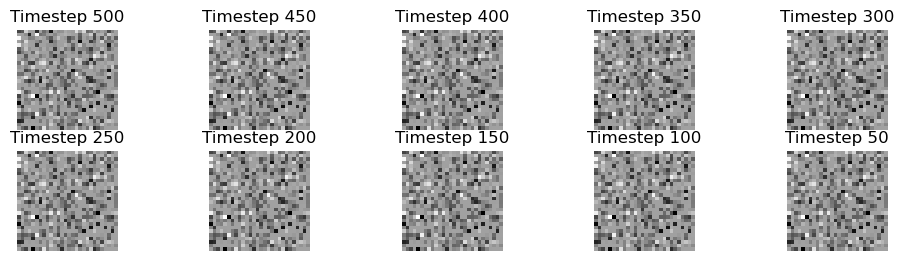

In [21]:
def visualize_reverse_diffusion_process(x0, diffusion_model):
    """
    可视化逐步去噪过程
    :param x0: 初始图像 batch
    :param diffusion_model: 扩散模型，包含正向扩散和反向扩散
    :param model: 去噪模型
    :param timesteps: 扩散时间步数
    :param device: 使用的设备（'cuda' 或 'cpu'）
    """
    # 使用 forward_diffusion 生成噪声图像
    batch_size = x0.size(0)
    t = torch.tensor([timesteps], device=device)  # 设置最大时间步
    noisy_img, _ = diffusion_model.forward_diffusion(x0, t)  # 添加噪声

    # 创建一个图形窗口
    plt.figure(figsize=(12, 6))
    
    # 在不同的时间步 t 下逐步去噪并可视化
    for step in range(timesteps, 0, -50):  # 这里我们每 50 步可视化一次，你可以根据需要调整
        t_val = torch.tensor([step], device=device, dtype=torch.float32)  # 当前时间步 t
        denoised_img = diffusion_model.reverse_diffusion(noisy_img, t_val)  # 反向扩散去噪

        # 可视化每一步去噪后的图像
        plt.subplot(4, 5, (timesteps - step) // 50 + 1)
        img = denoised_img[0].cpu().detach().squeeze()  # 取一张图片
        plt.imshow(img, cmap='gray')
        plt.title(f'Timestep {step}')
        plt.axis('off')

    # 显示最终去噪过程图像
    plt.show()

# 示例调用
x0 = next(iter(train_loader))[0].to(device)  # 获取一批真实图像，假设有 train_loader
visualize_reverse_diffusion_process(x0, diffusion_model)

In [12]:
'''
# 定义 U-Net 模型架构，用于去噪
class UNet(nn.Module):
    def __init__(self, input_channels=3, output_channels=3, hidden_dim=64):
        super(UNet, self).__init__()

        def block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )

        self.encoder = nn.Sequential(
            block(input_channels, hidden_dim),
            block(hidden_dim, hidden_dim * 2),
            block(hidden_dim * 2, hidden_dim * 4),
        )
        self.decoder = nn.Sequential(
            block(hidden_dim * 4, hidden_dim * 2),
            block(hidden_dim * 2, hidden_dim),
            block(hidden_dim, output_channels),
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# 生成时间步长的噪声
def noise_schedule(timesteps):
    return torch.linspace(0.0001, 0.02, timesteps)


# 前向过程：逐步给图像加噪
def forward_diffusion(x, t, noise_schedules):
    noise = torch.randn_like(x)
    sqrt_alpha_cumprod_t = torch.index_select(torch.sqrt(torch.cumprod(1.0 - noise_schedules, dim=0)), 0, t).view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1 - sqrt_alpha_cumprod_t).view(-1, 1, 1, 1)

    #sqrt_alpha_cumprod = torch.sqrt(torch.cumprod(1.0 - noise_schedules, dim=0))
    noisy_image = sqrt_one_minus_alpha_cumprod_t * x + torch.sqrt(1 - sqrt_one_minus_alpha_cumprod_t) * noise
    return noisy_image, noise


# 反向过程：使用模型预测噪声并去噪
def reverse_diffusion(model, noisy_image, t, noise_schedules):
    model.eval()
    predicted_noise = model(noisy_image)
    beta = noise_schedules[t].view(-1, 1, 1, 1)
    sqrt_alpha_cumprod = torch.sqrt(torch.cumprod(1.0 - noise_schedules, dim=0))
    posterior_mean = (1 / torch.sqrt(1.0 - beta)) * (noisy_image - beta * predicted_noise)
    return posterior_mean


# 加载 CIFAR-10 数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型、优化器和损失函数
timesteps = 1000
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# 噪声计划
noise_schedules = noise_schedule(timesteps).to(device)

# 训练模型
epochs = 5
for epoch in range(epochs):
    for i, (images, _) in enumerate(trainloader):
        images = images.to(device)
        t = torch.randint(0, timesteps, (images.size(0),), device=device).long()
        
        noisy_image, noise = forward_diffusion(images, t, noise_schedules)
        optimizer.zero_grad()
        predicted_noise = model(noisy_image)
        loss = criterion(predicted_noise, noise)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Step {i}/{len(trainloader)}, Loss: {loss.item()}')

# 生成新圖像
def sample_new_image(model, timesteps, noise_schedules, image_shape):
    model.eval()
    noisy_image = torch.randn(image_shape).to(device)

    for t in reversed(range(timesteps)):
        noisy_image = reverse_diffusion(model, noisy_image, t, noise_schedules)

    return noisy_image

# 示例生成图像
with torch.no_grad():
    new_image = sample_new_image(model, timesteps, noise_schedules, (1, 3, 32, 32))
    new_image = new_image.cpu().squeeze().permute(1, 2, 0)
    new_image = new_image * 0.5 + 0.5  # 反归一化

    plt.imshow(new_image.numpy())
    plt.show()
'''


Files already downloaded and verified
Epoch 1/5, Step 0/782, Loss: 1.1614460945129395
Epoch 1/5, Step 100/782, Loss: 0.6629166007041931
Epoch 1/5, Step 200/782, Loss: 0.64190274477005
Epoch 1/5, Step 300/782, Loss: 0.6478320956230164
Epoch 1/5, Step 400/782, Loss: 0.6438751220703125
Epoch 1/5, Step 500/782, Loss: 0.631695568561554
Epoch 1/5, Step 600/782, Loss: 0.6335991621017456


KeyboardInterrupt: 